In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv1D, Conv2D, Flatten, MaxPooling1D, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
import xgboost
from xgboost import XGBRegressor, XGBClassifier

In [4]:
#####################################
# IMPORT AUXILIARY/CUSTOM FUNCTIONS #
#####################################

from AUX_MLL_BL import max_num_bins, Z_BL_asimov, BL_test_fast, BL_test_fsolve, MLL_test_fast, MLL_test_fsolve


# AUX FUNCTION TO FIND SOLUTIONS

def dx(fn, x, delta=0.001):
    return (fn(x+delta) - fn(x))/delta

def solvecross(fn, value, x=-45.5, maxtries=1000, maxerr=0.00001):
    for tries in range(maxtries):
        err = fn(x) - value
        if abs(err) < maxerr:
            return x
        slope = dx(fn, x)
        x -= err/slope
    raise ValueError('no solution found')

### DATA

In [5]:
mDM = 500

filefolder = '../../data2024/processed/cs1cs2/'

In [6]:
##############
# PARAMETERS #
##############

tot_B = 634.55+2.26+0.01+0.6+5.34

f_ER = 634.55 / tot_B
f_AC = 2.26 / tot_B
f_CNNS = 0.01 / tot_B
f_RN = 0.6 / tot_B
f_WALL = 5.34 / tot_B

f_ER + f_AC + f_CNNS + f_RN + f_WALL

S_cross1045 = 33.24

cross_factor = np.logspace(-47,-44,10) / 1e-45
S_expected = [max(1, round(S_cross1045 * fac)) for fac in cross_factor]


# DISCOVERY: 'discovery', EXCLUSION: 'exclusion'
D_or_E = 'exclusion'

# requested number of pseudo experiments
num_pseudo = 2000

# number of expected background events per ensemble
B_expected = round(tot_B)

print('B_expected: ', B_expected)
print('S_cross1045: ', S_cross1045)
print('S_expected (from cross=1e-47 to 1e-44): ', S_expected)

B_expected:  643
S_cross1045:  33.24
S_expected (from cross=1e-47 to 1e-44):  [1, 1, 2, 3, 7, 15, 33, 72, 154, 332]


In [31]:
###############
# BACKGROUNDS # 
###############

B_cs1_ER = np.loadtxt(filefolder + 'ER_cs1.txt')
B_cs2_ER = np.loadtxt(filefolder + 'ER_cs2.txt')

print('B_cs1_ER.shape: ', B_cs1_ER.shape)
print('B_cs2_ER.shape: ', B_cs2_ER.shape)


B_cs1_AC = np.loadtxt(filefolder + 'AC_cs1.txt')
B_cs2_AC = np.loadtxt(filefolder + 'AC_cs2.txt')

print('\nB_cs1_AC.shape: ', B_cs1_AC.shape)
print('B_cs2_AC.shape: ', B_cs2_AC.shape)


B_cs1_CNNS = np.loadtxt(filefolder + 'CNNS_cs1.txt')
B_cs2_CNNS = np.loadtxt(filefolder + 'CNNS_cs2.txt')

print('\nB_cs1_CNNS.shape: ', B_cs1_CNNS.shape)
print('B_cs2_CNNS.shape: ', B_cs2_CNNS.shape)


B_cs1_RN = np.loadtxt(filefolder + 'RN_cs1.txt')
B_cs2_RN = np.loadtxt(filefolder + 'RN_cs2.txt')

print('\nB_cs1_RN.shape: ', B_cs1_RN.shape)
print('B_cs2_RN.shape: ', B_cs2_RN.shape)


B_cs1_WALL = np.loadtxt(filefolder + 'WALL_cs1.txt')
B_cs2_WALL = np.loadtxt(filefolder + 'WALL_cs2.txt')

print('\nB_cs1_WALL.shape: ', B_cs1_WALL.shape)
print('B_cs2_WALL.shape: ', B_cs2_WALL.shape)


##########
# SIGNAL #
##########

S_cs1 = np.loadtxt(filefolder + 'WIMP_' + str(mDM) + 'GeV_cs1.txt')
S_cs2 = np.loadtxt(filefolder + 'WIMP_' + str(mDM) + 'GeV_cs2.txt')

print('\nS_cs1.shape: ', S_cs1.shape)
print('S_cs2.shape: ', S_cs2.shape)

B_cs1_ER.shape:  (67300,)
B_cs2_ER.shape:  (67300,)

B_cs1_AC.shape:  (5000,)
B_cs2_AC.shape:  (5000,)

B_cs1_CNNS.shape:  (43,)
B_cs2_CNNS.shape:  (43,)

B_cs1_RN.shape:  (4516,)
B_cs2_RN.shape:  (4516,)

B_cs1_WALL.shape:  (5000,)
B_cs2_WALL.shape:  (5000,)

S_cs1.shape:  (35477,)
S_cs2.shape:  (35477,)


In [32]:
# cs1 = [3, 70] PE
# cS2 = [50, 8000] PE

B_cs1_ER_aux = [B_cs1_ER[x] for x in range(len(B_cs1_ER)) if (3 < B_cs1_ER[x] < 70 and 50 < B_cs2_ER[x] < 8000)]
B_cs2_ER = [B_cs2_ER[x] for x in range(len(B_cs1_ER)) if (3 < B_cs1_ER[x] < 70 and 50 < B_cs2_ER[x] < 8000)]
B_cs1_ER = B_cs1_ER_aux

B_cs1_AC_aux = [B_cs1_AC[x] for x in range(len(B_cs1_AC)) if (3 < B_cs1_AC[x] < 70 and 50 < B_cs2_AC[x] < 8000)]
B_cs2_AC = [B_cs2_AC[x] for x in range(len(B_cs1_AC)) if (3 < B_cs1_AC[x] < 70 and 50 < B_cs2_AC[x] < 8000)]
B_cs1_AC = B_cs1_AC_aux

B_cs1_CNNS_aux = [B_cs1_CNNS[x] for x in range(len(B_cs1_CNNS)) if (3 < B_cs1_CNNS[x] < 70 and 50 < B_cs2_CNNS[x] < 8000)]
B_cs2_CNNS = [B_cs2_CNNS[x] for x in range(len(B_cs1_CNNS)) if (3 < B_cs1_CNNS[x] < 70 and 50 < B_cs2_CNNS[x] < 8000)]
B_cs1_CNNS = B_cs1_CNNS_aux

B_cs1_RN_aux = [B_cs1_RN[x] for x in range(len(B_cs1_RN)) if (3 < B_cs1_RN[x] < 70 and 50 < B_cs2_RN[x] < 8000)]
B_cs2_RN = [B_cs2_RN[x] for x in range(len(B_cs1_RN)) if (3 < B_cs1_RN[x] < 70 and 50 < B_cs2_RN[x] < 8000)]
B_cs1_RN = B_cs1_RN_aux

B_cs1_WALL_aux = [B_cs1_WALL[x] for x in range(len(B_cs1_WALL)) if (3 < B_cs1_WALL[x] < 70 and 50 < B_cs2_WALL[x] < 8000)]
B_cs2_WALL = [B_cs2_WALL[x] for x in range(len(B_cs1_WALL)) if (3 < B_cs1_WALL[x] < 70 and 50 < B_cs2_WALL[x] < 8000)]
B_cs1_WALL = B_cs1_WALL_aux


S_cs1_aux = [S_cs1[x] for x in range(len(S_cs1)) if (3 < S_cs1[x] < 70 and 50 < S_cs2[x] < 8000)]
S_cs2 = [S_cs2[x] for x in range(len(S_cs1)) if (3 < S_cs1[x] < 70 and 50 < S_cs2[x] < 8000)]
S_cs1 = S_cs1_aux


##### Select the number of events per class

In [33]:
NUM_DAT = min(len(B_cs1_ER), len(S_cs1))
print(' NUM_DAT: ', NUM_DAT, '\n')

NUM_DAT_AC = int(NUM_DAT*f_AC)
NUM_DAT_CNNS = max(1, int(NUM_DAT*f_CNNS))
NUM_DAT_RN = int(NUM_DAT*f_RN)
NUM_DAT_WALL = int(NUM_DAT*f_WALL)

NUM_DAT_ER = NUM_DAT - ( NUM_DAT_AC + NUM_DAT_CNNS + NUM_DAT_RN + NUM_DAT_WALL )

print('NUM_DAT_ER: ', NUM_DAT_ER)
print('NUM_DAT_AC: ', NUM_DAT_AC)
print('NUM_DAT_CNNS: ', NUM_DAT_CNNS)
print('NUM_DAT_RN: ', NUM_DAT_RN)
print('NUM_DAT_WALL: ', NUM_DAT_WALL)



# CONCATENATE THE BACKGROUNDS
B_cs1cs2 = np.concatenate([np.stack([B_cs1_ER,B_cs2_ER],axis=1)[:NUM_DAT_ER], np.stack([B_cs1_AC,B_cs2_AC],axis=1)[:NUM_DAT_AC], np.stack([B_cs1_CNNS,B_cs2_CNNS],axis=1)[:NUM_DAT_CNNS], np.stack([B_cs1_RN,B_cs2_RN],axis=1)[:NUM_DAT_RN], np.stack([B_cs1_WALL,B_cs2_WALL],axis=1)[:NUM_DAT_WALL]])

print('\nB_cs1cs2.shape: ', B_cs1cs2.shape)


S_cs1cs2 = np.stack([S_cs1,S_cs2],axis=1)[:NUM_DAT]


print('\nS_cs1cs2.shape: ', S_cs1cs2.shape)

 NUM_DAT:  32117 

NUM_DAT_ER:  31709
NUM_DAT_AC:  112
NUM_DAT_CNNS:  1
NUM_DAT_RN:  29
NUM_DAT_WALL:  266

B_cs1cs2.shape:  (32117, 2)

S_cs1cs2.shape:  (32117, 2)


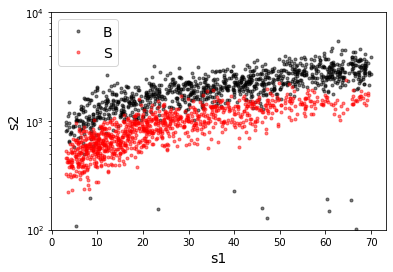

In [34]:
rnd = 100

B_cs1cs2_plot = shuffle(B_cs1cs2, random_state=rnd)
S_cs1cs2_plot = shuffle(S_cs1cs2, random_state=rnd)

plt.plot(B_cs1cs2_plot[:,0][:1000], B_cs1cs2_plot[:,1][:1000], '.', color='black', alpha=0.5, label='B')
plt.plot(S_cs1cs2_plot[:,0][:1000], S_cs1cs2_plot[:,1][:1000], '.', color='red', alpha=0.5, label='S')
plt.yscale('log')
# plt.xlim([0,100])
plt.ylim([100,10000])
plt.xlabel('s1',fontsize=14)
plt.ylabel('s2',fontsize=14)
plt.legend(fontsize=14)
plt.show()

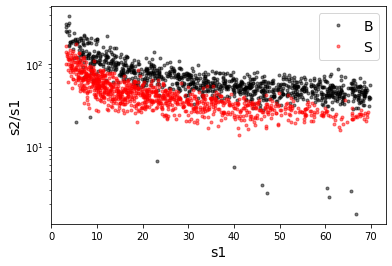

In [35]:
plt.plot(B_cs1cs2_plot[:,0][:1000], (B_cs1cs2_plot[:,1] / B_cs1cs2_plot[:,0])[:1000], '.', color='black', alpha=0.5, label='B')
plt.plot(S_cs1cs2_plot[:,0][:1000], (S_cs1cs2_plot[:,1] / S_cs1cs2_plot[:,0])[:1000], '.', color='red', alpha=0.5, label='S')
plt.yscale('log')
# plt.xlim([0,100])
# plt.ylim([100,10000])
plt.xlabel('s1',fontsize=14)
plt.ylabel('s2/s1',fontsize=14)
plt.legend(fontsize=14)
plt.show()

## 1. cS1 and cS2

In [36]:
# concatenate the data
X_mon_B = B_cs1cs2
X_mon_S = S_cs1cs2

# X_mon_B = np.reshape(B_pdiffT,(len(B_pdiffT),1))
# X_mon_S = np.reshape(S_pdiffT,(len(S_pdiffT),1))
print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)

# del B_ppeakS1
# del B_ppeakS2
# del B_pbot
# del B_ptop

# del S_ppeakS1
# del S_ppeakS2
# del S_pbot
# del S_ptop

X_mon = np.concatenate([X_mon_B, X_mon_S])

# X_mon = np.concatenate([np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(S_pbot,(len(S_pbot),1))])

print('X_mon.shape: ', X_mon.shape)
# del X_mon_B
# del X_mon_S


# labels
y_mon = np.concatenate([np.zeros(NUM_DAT),np.ones(NUM_DAT)])


# divide into train-val and test data samples
test_ratio = 0.25
val_ratio = 0.15


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)

del X_mon
del y_mon

X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)

del X_mon_aux
del y_mon_aux

print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')

X_mon_B.shape:  (32117, 2)
X_mon_S.shape:  (32117, 2)
X_mon.shape:  (64234, 2)

X_mon_train :  (40948, 2)
y_mon_train :  (40948,)
X_mon_val :  (7227, 2)
y_mon_val :  (7227,)
X_mon_test :  (16059, 2)
y_mon_test :  (16059,)



## CLASSIFIERS

### XGBoost

[0]	validation_0-logloss:0.62132	validation_1-logloss:0.62155
[1]	validation_0-logloss:0.56222	validation_1-logloss:0.56282
[2]	validation_0-logloss:0.51300	validation_1-logloss:0.51380
[3]	validation_0-logloss:0.47159	validation_1-logloss:0.47261


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[4]	validation_0-logloss:0.43611	validation_1-logloss:0.43755
[5]	validation_0-logloss:0.40524	validation_1-logloss:0.40664
[6]	validation_0-logloss:0.37886	validation_1-logloss:0.38061
[7]	validation_0-logloss:0.35578	validation_1-logloss:0.35779
[8]	validation_0-logloss:0.33566	validation_1-logloss:0.33778
[9]	validation_0-logloss:0.31816	validation_1-logloss:0.32036
[10]	validation_0-logloss:0.30266	validation_1-logloss:0.30508
[11]	validation_0-logloss:0.28904	validation_1-logloss:0.29153
[12]	validation_0-logloss:0.27696	validation_1-logloss:0.27954
[13]	validation_0-logloss:0.26645	validation_1-logloss:0.26915
[14]	validation_0-logloss:0.25692	validation_1-logloss:0.25977
[15]	validation_0-logloss:0.24859	validation_1-logloss:0.25160
[16]	validation_0-logloss:0.24110	validation_1-logloss:0.24415
[17]	validation_0-logloss:0.23457	validation_1-logloss:0.23758
[18]	validation_0-logloss:0.22864	validation_1-logloss:0.23163
[19]	validation_0-logloss:0.22345	validation_1-logloss:0.2265

[134]	validation_0-logloss:0.17159	validation_1-logloss:0.18289
[135]	validation_0-logloss:0.17158	validation_1-logloss:0.18287
[136]	validation_0-logloss:0.17147	validation_1-logloss:0.18281
[137]	validation_0-logloss:0.17143	validation_1-logloss:0.18283
[138]	validation_0-logloss:0.17141	validation_1-logloss:0.18284
[139]	validation_0-logloss:0.17126	validation_1-logloss:0.18285
[140]	validation_0-logloss:0.17118	validation_1-logloss:0.18283
[141]	validation_0-logloss:0.17105	validation_1-logloss:0.18285
[142]	validation_0-logloss:0.17091	validation_1-logloss:0.18288
[143]	validation_0-logloss:0.17086	validation_1-logloss:0.18287
[144]	validation_0-logloss:0.17082	validation_1-logloss:0.18290
[145]	validation_0-logloss:0.17079	validation_1-logloss:0.18293
[146]	validation_0-logloss:0.17072	validation_1-logloss:0.18294


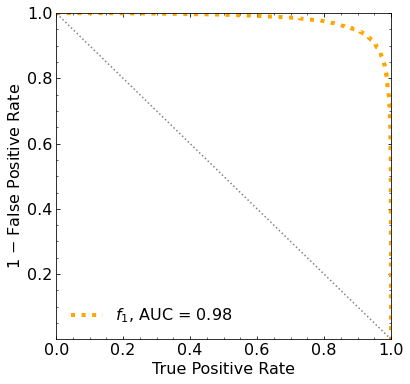

Classification score:


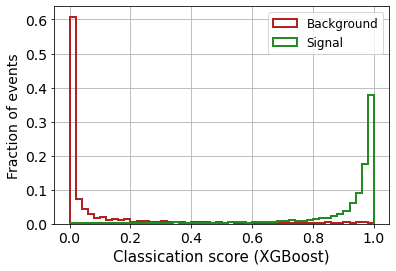


 ROC-AUC =  0.9799047266550882


In [13]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

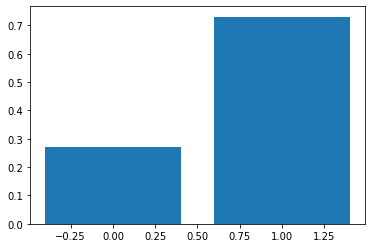

In [14]:
plt.bar(range(len(classifier.feature_importances_)), classifier.feature_importances_)
plt.show()

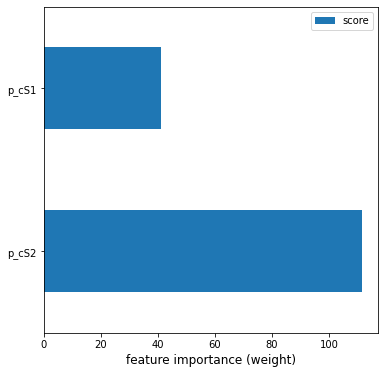

In [15]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
keys = ['p_cS1','p_cS2']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 40 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()

In [16]:
keys

['p_cS1', 'p_cS2']

In [17]:

from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(classifier, X_mon_test, y_mon_test)


In [18]:


sorted_idx = classifier.feature_importances_.argsort()

sorted_idx_keys = []
for i in sorted_idx:
    sorted_idx_keys.append(keys[i])
    
sorted_idx_keys

['p_cS1', 'p_cS2']

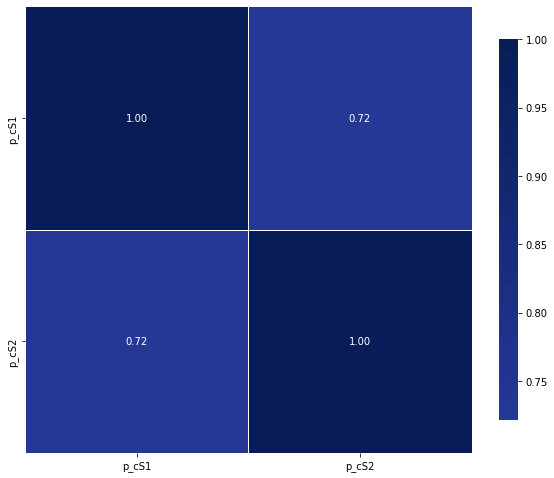

In [19]:
X = pd.DataFrame(X_mon_test, columns=keys)

def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show();
    
correlation_heatmap(X[sorted_idx_keys])


In [20]:
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]] # range of our data (between 0 and 1 if its the ML output)

bins_to_test=range(1,500) # number of bins we are testing to see if condition holds

# FIND THE NUMBER OF BINS:
num_bins = max_num_bins(pred_XG_SM, B_expected, range_dat, MIN_EVS, bins_to_test)

print('\n FOR BIN LIKELIHOOD WE ARE SETTING:')
print('min number of Background events allowed per bin: ', MIN_EVS)
print('number of bins we are going to use: ', num_bins)
print('range of our data: ', range_dat)

At least 5 B events per bin, range = [[0, 1]]:
# bins:  18 OK

 FOR BIN LIKELIHOOD WE ARE SETTING:
min number of Background events allowed per bin:  5
number of bins we are going to use:  18
range of our data:  [[0, 1]]


In [21]:
num_bins = 10

B_expected:  643
S_expected:  1

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0795


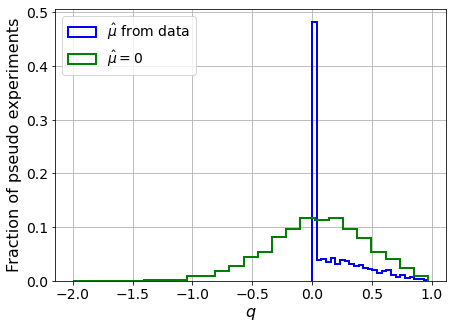

muhat mean:  0.09355901550241459
Z_bins:  0.24007308332059546
std Z_bins:  0.48114080181201446
Z_bins mu=0:  0.24007308332059546
std Z_bins mu=0:  0.8329448035918536

--------

B_expected:  643
S_expected:  1

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0925


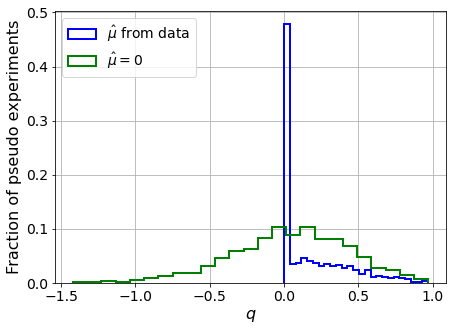

muhat mean:  0.04615977059220452
Z_bins:  0.25332558207388683
std Z_bins:  0.45484009582678914
Z_bins mu=0:  0.25332558207388683
std Z_bins mu=0:  0.7826530040895409

--------

B_expected:  643
S_expected:  2

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0895


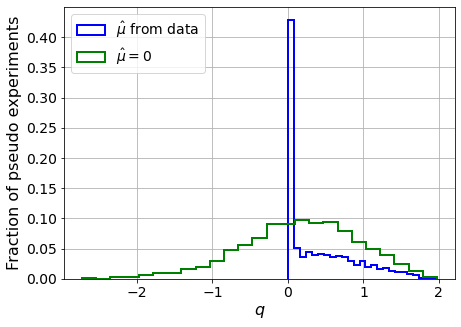

muhat mean:  0.06962872743772391
Z_bins:  0.44213888882306285
std Z_bins:  0.526629902071561
Z_bins mu=0:  0.44213888882306285
std Z_bins mu=0:  0.8678827793434122

--------

B_expected:  643
S_expected:  3

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0915


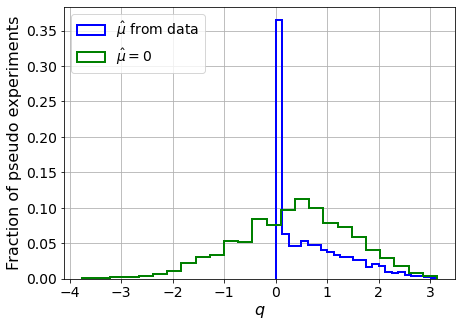

muhat mean:  0.029955156022940438
Z_bins:  0.6655114173146214
std Z_bins:  0.5434887534577661
Z_bins mu=0:  0.6655114173146214
std Z_bins mu=0:  0.832022903753395

--------

B_expected:  643
S_expected:  7

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0915


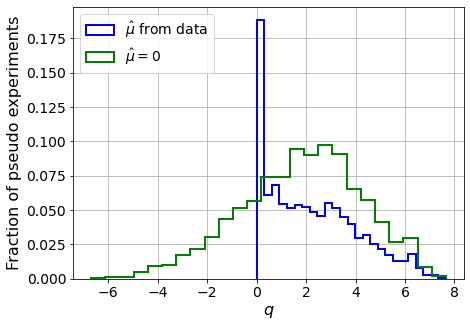

muhat mean:  0.01872949321345192
Z_bins:  1.4050677504948323
std Z_bins:  0.6470635046045489
Z_bins mu=0:  1.4050677504948323
std Z_bins mu=0:  0.8701204644542506

--------

B_expected:  643
S_expected:  15

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0805


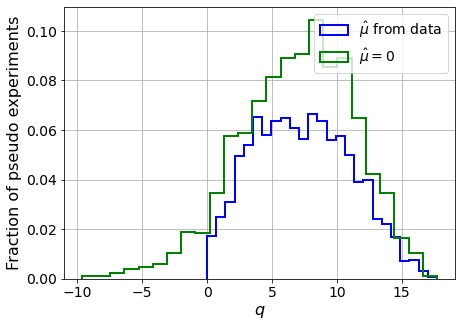

muhat mean:  0.001490367606799927
Z_bins:  2.6868808066387135
std Z_bins:  0.69051504214627
Z_bins mu=0:  2.6868808066387135
std Z_bins mu=0:  0.8185755944053548

--------

B_expected:  643
S_expected:  33

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.078


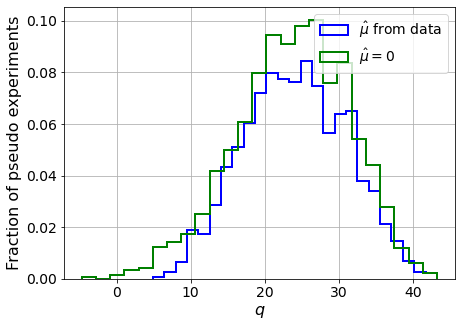

muhat mean:  0.003995111477551173
Z_bins:  4.91357461565683
std Z_bins:  0.7020471943636546
Z_bins mu=0:  4.912301205951831
std Z_bins mu=0:  0.7762280304641838

--------

B_expected:  643
S_expected:  72

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0805


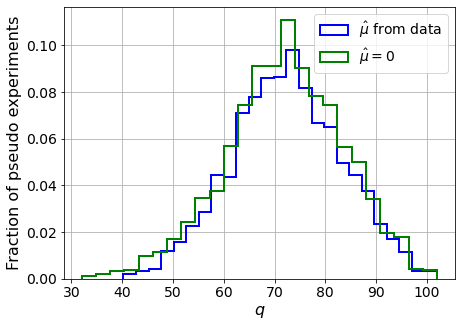

muhat mean:  0.0006939278763567467
Z_bins:  8.509972499223139
std Z_bins:  0.639560116528338
Z_bins mu=0:  8.509835083168038
std Z_bins mu=0:  0.6795893854481624

--------

B_expected:  643
S_expected:  154

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.1


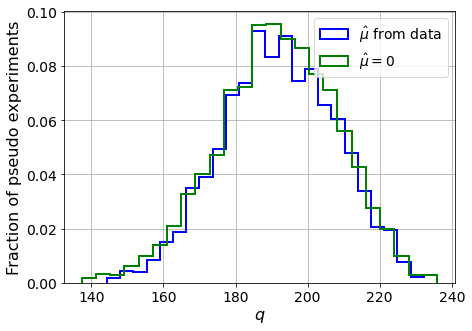

muhat mean:  0.0005466976845555998
Z_bins:  13.861145132334654
std Z_bins:  0.5715662056157359
Z_bins mu=0:  13.860821020955202
std Z_bins mu=0:  0.595863186679928

--------

B_expected:  643
S_expected:  332

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0965


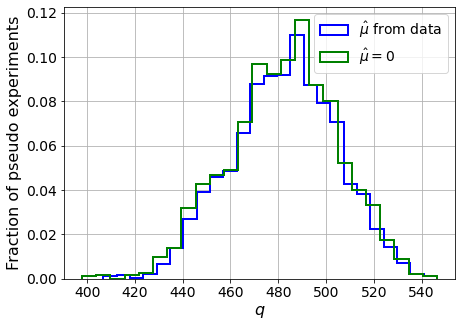

muhat mean:  0.00035987124453519195
Z_bins:  21.984879467798162
std Z_bins:  0.5007524833247375
Z_bins mu=0:  21.983056448647385
std Z_bins mu=0:  0.5158675928953323

--------


 FINAL RESULT:

[[0.24007308332059546, 0.48114080181201446, 0.09355901550241459, 0.24007308332059546, 0.8329448035918536], [0.25332558207388683, 0.45484009582678914, 0.04615977059220452, 0.25332558207388683, 0.7826530040895409], [0.44213888882306285, 0.526629902071561, 0.06962872743772391, 0.44213888882306285, 0.8678827793434122], [0.6655114173146214, 0.5434887534577661, 0.029955156022940438, 0.6655114173146214, 0.832022903753395], [1.4050677504948323, 0.6470635046045489, 0.01872949321345192, 1.4050677504948323, 0.8701204644542506], [2.6868808066387135, 0.69051504214627, 0.001490367606799927, 2.6868808066387135, 0.8185755944053548], [4.91357461565683, 0.7020471943636546, 0.003995111477551173, 4.912301205951831, 0.7762280304641838], [8.509972499223139, 0.639560116528338, 0.0006939278763567467, 8.509835083168038,

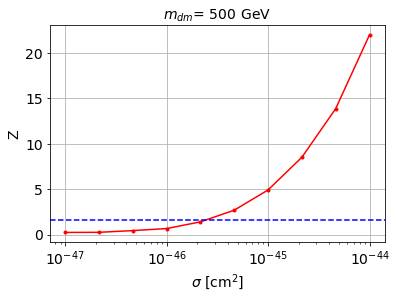


cross_BL_164:  2.4798594683951385e-46
cross_BL_164_up:  1.4804594905161264e-46
cross_BL_164_down:  3.721711191350428e-46


In [22]:
# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []


for s_it in range(len(S_expected)):
    
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[s_it])
    print('')

    Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, S_expected[s_it], num_pseudo, num_bins, range_dat, MIN_EVS, linear_bins=True) 
    
    store_Z_BL.append( list(Z_BL) )
    
    print('muhat mean: ', Z_BL[2])
    print('Z_bins: ', Z_BL[0])
    print('std Z_bins: ', Z_BL[1])
    print('Z_bins mu=0: ', Z_BL[3])
    print('std Z_bins mu=0: ', Z_BL[4])
    print('')
    print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)


# plot
plt.plot(cross_factor*1e-45, np.array(store_Z_BL)[:,0], '.-', c='red')

plt.axhline(y=1.64, c='blue', linestyle='--')
plt.title('$m_{dm}$= %0.2d GeV' % mDM, fontsize=14)
plt.xscale('log')
plt.xlabel(r'$\sigma$ [cm$^2$]', fontsize=14)
plt.ylabel(r'Z', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()


# interpolate
f_Z = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0], kind='linear')
f_Z_up = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0] + np.array(store_Z_BL)[:,1], kind='linear')
f_Z_down = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0] - np.array(store_Z_BL)[:,1], kind='linear')

# compute the cross section with Z=1.64
cross_BL_164 = 10**solvecross(f_Z, 1.64)
cross_BL_164_up = 10**solvecross(f_Z_up, 1.64)
cross_BL_164_down = 10**solvecross(f_Z_down, 1.64)

print('\ncross_BL_164: ', cross_BL_164)
print('cross_BL_164_up: ', cross_BL_164_up)
print('cross_BL_164_down: ', cross_BL_164_down)

### DNN

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 4)                 12        
_________________________________________________________________
dropout_7 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                80        
_________________________________________________________________
dropout_8 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 68        
_________________________________________________________________
dropout_9 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

320/320 [==============================] - 0s 542us/step - loss: 0.3020 - accuracy: 0.8735 - val_loss: 0.2241 - val_accuracy: 0.9076
Epoch 49/500
320/320 [==============================] - 0s 545us/step - loss: 0.2981 - accuracy: 0.8747 - val_loss: 0.2479 - val_accuracy: 0.8936
Epoch 50/500
320/320 [==============================] - 0s 582us/step - loss: 0.2906 - accuracy: 0.8809 - val_loss: 0.2458 - val_accuracy: 0.8944
Epoch 51/500
320/320 [==============================] - 0s 552us/step - loss: 0.2950 - accuracy: 0.8778 - val_loss: 0.2623 - val_accuracy: 0.8813
Epoch 52/500
320/320 [==============================] - 0s 569us/step - loss: 0.2884 - accuracy: 0.8800 - val_loss: 0.2703 - val_accuracy: 0.8843
Epoch 53/500
320/320 [==============================] - 0s 555us/step - loss: 0.2929 - accuracy: 0.8795 - val_loss: 0.2483 - val_accuracy: 0.8935
Epoch 54/500
320/320 [==============================] - 0s 567us/step - loss: 0.2937 - accuracy: 0.8770 - val_loss: 0.2597 - val_accuracy

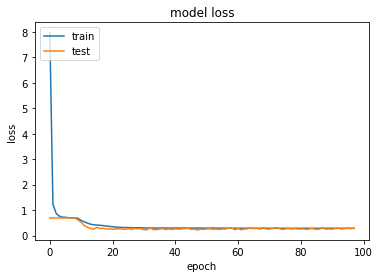

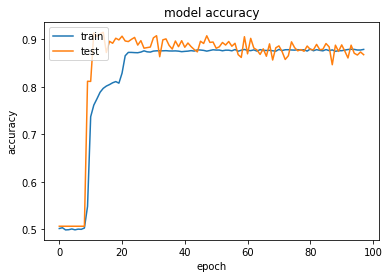

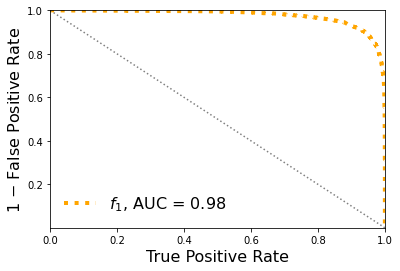

Classification score:


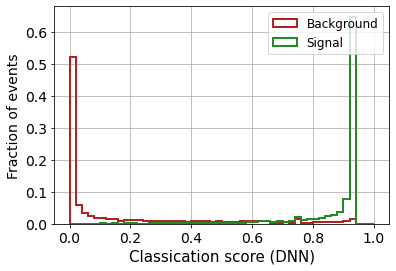


 ROC-AUC =  0.9753163328065204


In [37]:

# define the keras model
model = Sequential()
model.add(Dense(4, input_shape=(X_mon_train.shape[1],), activation='relu'))
model.add(Dropout(0.20))
# model.add(Dense(8, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

### CNN

In [24]:
# prepare the dataset
X_mon_train_cn = X_mon_train.reshape(X_mon_train.shape[0], X_mon_train.shape[1], 1)
X_mon_test_cn = X_mon_test.reshape(X_mon_test.shape[0], X_mon_test.shape[1], 1)
X_mon_val_cn = X_mon_val.reshape(X_mon_val.shape[0], X_mon_val.shape[1], 1)

Epoch 1/500
320/320 [==============================] - 1s 1ms/step - loss: 36.2475 - accuracy: 0.5265 - val_loss: 0.4839 - val_accuracy: 0.7500
Epoch 2/500
320/320 [==============================] - 0s 512us/step - loss: 0.5082 - accuracy: 0.6946 - val_loss: 0.4457 - val_accuracy: 0.7832
Epoch 3/500
320/320 [==============================] - 0s 509us/step - loss: 0.4843 - accuracy: 0.7268 - val_loss: 0.4112 - val_accuracy: 0.8402
Epoch 4/500
320/320 [==============================] - 0s 503us/step - loss: 0.4618 - accuracy: 0.7539 - val_loss: 0.4097 - val_accuracy: 0.8975
Epoch 5/500
320/320 [==============================] - 0s 504us/step - loss: 0.4487 - accuracy: 0.7776 - val_loss: 0.3515 - val_accuracy: 0.8941
Epoch 6/500
320/320 [==============================] - 0s 533us/step - loss: 0.4228 - accuracy: 0.7962 - val_loss: 0.3294 - val_accuracy: 0.9078
Epoch 7/500
320/320 [==============================] - 0s 522us/step - loss: 0.4046 - accuracy: 0.8103 - val_loss: 0.3019 - val_acc

320/320 [==============================] - 0s 505us/step - loss: 0.3127 - accuracy: 0.8324 - val_loss: 0.2102 - val_accuracy: 0.9243
Epoch 58/500
320/320 [==============================] - 0s 512us/step - loss: 0.3078 - accuracy: 0.8363 - val_loss: 0.2298 - val_accuracy: 0.9214
Epoch 59/500
320/320 [==============================] - 0s 495us/step - loss: 0.3020 - accuracy: 0.8353 - val_loss: 0.2104 - val_accuracy: 0.9236
Epoch 60/500
320/320 [==============================] - 0s 506us/step - loss: 0.3065 - accuracy: 0.8318 - val_loss: 0.2155 - val_accuracy: 0.9239
Epoch 61/500
320/320 [==============================] - 0s 510us/step - loss: 0.3041 - accuracy: 0.8360 - val_loss: 0.2011 - val_accuracy: 0.9229
Epoch 62/500
320/320 [==============================] - 0s 499us/step - loss: 0.3028 - accuracy: 0.8334 - val_loss: 0.1946 - val_accuracy: 0.9243
Epoch 63/500
320/320 [==============================] - 0s 513us/step - loss: 0.3027 - accuracy: 0.8365 - val_loss: 0.2157 - val_accuracy

320/320 [==============================] - 0s 508us/step - loss: 0.3028 - accuracy: 0.8355 - val_loss: 0.2030 - val_accuracy: 0.9232
Epoch 114/500
320/320 [==============================] - 0s 505us/step - loss: 0.2989 - accuracy: 0.8356 - val_loss: 0.2028 - val_accuracy: 0.9214
Epoch 115/500
320/320 [==============================] - 0s 499us/step - loss: 0.3028 - accuracy: 0.8389 - val_loss: 0.2099 - val_accuracy: 0.9235
Epoch 116/500
320/320 [==============================] - 0s 506us/step - loss: 0.3017 - accuracy: 0.8360 - val_loss: 0.2137 - val_accuracy: 0.9160
Epoch 117/500
320/320 [==============================] - 0s 509us/step - loss: 0.3059 - accuracy: 0.8362 - val_loss: 0.2214 - val_accuracy: 0.9235
Epoch 118/500
320/320 [==============================] - 0s 500us/step - loss: 0.3048 - accuracy: 0.8370 - val_loss: 0.2147 - val_accuracy: 0.9159
Epoch 119/500
320/320 [==============================] - 0s 503us/step - loss: 0.3053 - accuracy: 0.8344 - val_loss: 0.2004 - val_ac

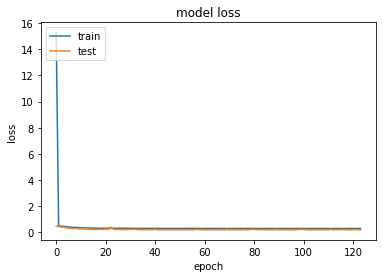

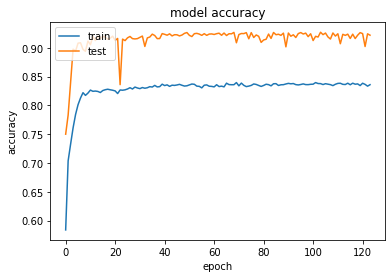

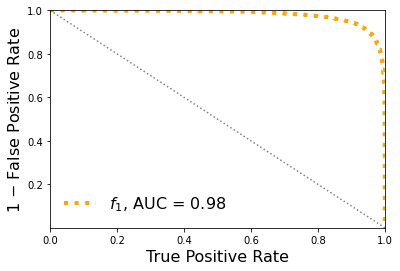

Classification score:


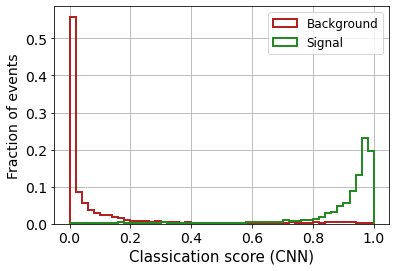


 ROC-AUC =  0.9795082287602611


In [25]:

# define the keras model
model = Sequential()
model.add(Conv1D(16, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
#model.add(MaxPooling1D(2, strides = (1)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

## 2. only 1 variable: cs2/cs1

In [26]:
# concatenate the data
X_mon_B = np.reshape( (B_cs1cs2[:,1] / B_cs1cs2[:,0]), [len(B_cs1cs2), 1])
X_mon_S = np.reshape( (S_cs1cs2[:,1] / S_cs1cs2[:,0]), [len(S_cs1cs2), 1])

# X_mon_B = np.reshape(B_pdiffT,(len(B_pdiffT),1))
# X_mon_S = np.reshape(S_pdiffT,(len(S_pdiffT),1))
print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)

# del B_ppeakS1
# del B_ppeakS2
# del B_pbot
# del B_ptop

# del S_ppeakS1
# del S_ppeakS2
# del S_pbot
# del S_ptop

X_mon = np.concatenate([X_mon_B, X_mon_S])

# X_mon = np.concatenate([np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(S_pbot,(len(S_pbot),1))])

print('X_mon.shape: ', X_mon.shape)
# del X_mon_B
# del X_mon_S


# labels
y_mon = np.concatenate([np.zeros(NUM_DAT),np.ones(NUM_DAT)])


# divide into train-val and test data samples
test_ratio = 0.25
val_ratio = 0.15


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)

del X_mon
del y_mon

X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)

del X_mon_aux
del y_mon_aux

print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')

X_mon_B.shape:  (32117, 1)
X_mon_S.shape:  (32117, 1)
X_mon.shape:  (64234, 1)

X_mon_train :  (40948, 1)
y_mon_train :  (40948,)
X_mon_val :  (7227, 1)
y_mon_val :  (7227,)
X_mon_test :  (16059, 1)
y_mon_test :  (16059,)



## CLASSIFIERS

### XGBoost

[0]	validation_0-logloss:0.66997	validation_1-logloss:0.66990
[1]	validation_0-logloss:0.65107	validation_1-logloss:0.65101
[2]	validation_0-logloss:0.63548	validation_1-logloss:0.63546
[3]	validation_0-logloss:0.62254	validation_1-logloss:0.62254
[4]	validation_0-logloss:0.61174	validation_1-logloss:0.61173


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[5]	validation_0-logloss:0.60266	validation_1-logloss:0.60276
[6]	validation_0-logloss:0.59501	validation_1-logloss:0.59521
[7]	validation_0-logloss:0.58850	validation_1-logloss:0.58881
[8]	validation_0-logloss:0.58297	validation_1-logloss:0.58339
[9]	validation_0-logloss:0.57829	validation_1-logloss:0.57883
[10]	validation_0-logloss:0.57429	validation_1-logloss:0.57492
[11]	validation_0-logloss:0.57085	validation_1-logloss:0.57172
[12]	validation_0-logloss:0.56791	validation_1-logloss:0.56893
[13]	validation_0-logloss:0.56537	validation_1-logloss:0.56657
[14]	validation_0-logloss:0.56314	validation_1-logloss:0.56446
[15]	validation_0-logloss:0.56124	validation_1-logloss:0.56265
[16]	validation_0-logloss:0.55962	validation_1-logloss:0.56107
[17]	validation_0-logloss:0.55817	validation_1-logloss:0.55982
[18]	validation_0-logloss:0.55695	validation_1-logloss:0.55874
[19]	validation_0-logloss:0.55590	validation_1-logloss:0.55782
[20]	validation_0-logloss:0.55498	validation_1-logloss:0.557

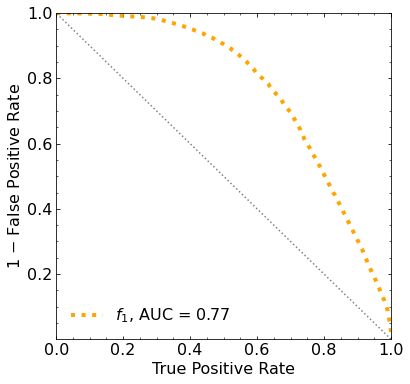

Classification score:


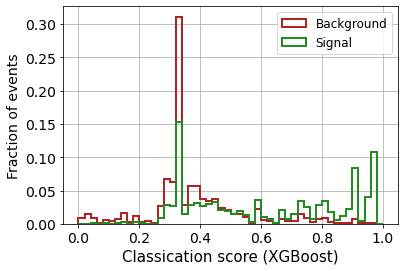


 ROC-AUC =  0.7700042087330574


In [27]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [28]:
print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.7700042087330574


### DNN

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 4)                 8         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                80        
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 68        
_________________________________________________________________
dropout_6 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

320/320 [==============================] - 0s 532us/step - loss: 0.6375 - accuracy: 0.6497 - val_loss: 0.6290 - val_accuracy: 0.6310
Epoch 49/500
320/320 [==============================] - 0s 532us/step - loss: 0.6377 - accuracy: 0.6496 - val_loss: 0.6327 - val_accuracy: 0.6210
Epoch 50/500
320/320 [==============================] - 0s 544us/step - loss: 0.6381 - accuracy: 0.6477 - val_loss: 0.6345 - val_accuracy: 0.6207
Epoch 51/500
320/320 [==============================] - 0s 555us/step - loss: 0.6392 - accuracy: 0.6435 - val_loss: 0.6431 - val_accuracy: 0.6110
Epoch 52/500
320/320 [==============================] - 0s 547us/step - loss: 0.6387 - accuracy: 0.6456 - val_loss: 0.6341 - val_accuracy: 0.6199
Epoch 53/500
320/320 [==============================] - 0s 544us/step - loss: 0.6370 - accuracy: 0.6494 - val_loss: 0.6300 - val_accuracy: 0.6221
Epoch 54/500
320/320 [==============================] - 0s 539us/step - loss: 0.6330 - accuracy: 0.6504 - val_loss: 0.6390 - val_accuracy

320/320 [==============================] - 0s 536us/step - loss: 0.6280 - accuracy: 0.6541 - val_loss: 0.6134 - val_accuracy: 0.6718
Epoch 105/500
320/320 [==============================] - 0s 544us/step - loss: 0.6313 - accuracy: 0.6464 - val_loss: 0.6070 - val_accuracy: 0.6967
Epoch 106/500
320/320 [==============================] - 0s 530us/step - loss: 0.6242 - accuracy: 0.6572 - val_loss: 0.6137 - val_accuracy: 0.6539
Epoch 107/500
320/320 [==============================] - 0s 539us/step - loss: 0.6236 - accuracy: 0.6579 - val_loss: 0.6118 - val_accuracy: 0.6733
Epoch 108/500
320/320 [==============================] - 0s 534us/step - loss: 0.6304 - accuracy: 0.6507 - val_loss: 0.6075 - val_accuracy: 0.6925
Epoch 109/500
320/320 [==============================] - 0s 548us/step - loss: 0.6270 - accuracy: 0.6533 - val_loss: 0.6059 - val_accuracy: 0.7024
Epoch 110/500
320/320 [==============================] - 0s 584us/step - loss: 0.6247 - accuracy: 0.6555 - val_loss: 0.6059 - val_ac

Epoch 160/500
320/320 [==============================] - 0s 532us/step - loss: 0.6238 - accuracy: 0.6560 - val_loss: 0.6071 - val_accuracy: 0.7076
Epoch 161/500
320/320 [==============================] - 0s 585us/step - loss: 0.6266 - accuracy: 0.6509 - val_loss: 0.6043 - val_accuracy: 0.7082
Epoch 162/500
320/320 [==============================] - 0s 524us/step - loss: 0.6259 - accuracy: 0.6523 - val_loss: 0.6033 - val_accuracy: 0.7076
Epoch 163/500
320/320 [==============================] - 0s 537us/step - loss: 0.6276 - accuracy: 0.6496 - val_loss: 0.6030 - val_accuracy: 0.7079
Epoch 164/500
320/320 [==============================] - 0s 538us/step - loss: 0.6274 - accuracy: 0.6476 - val_loss: 0.6053 - val_accuracy: 0.7065
Epoch 165/500
320/320 [==============================] - 0s 533us/step - loss: 0.6255 - accuracy: 0.6515 - val_loss: 0.6065 - val_accuracy: 0.7072
Epoch 166/500
320/320 [==============================] - 0s 537us/step - loss: 0.6279 - accuracy: 0.6515 - val_loss: 0

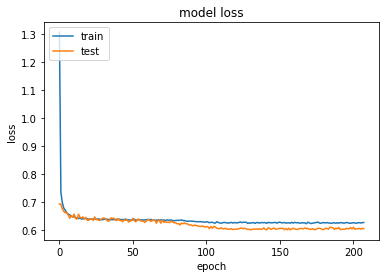

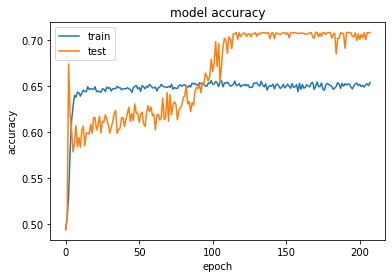

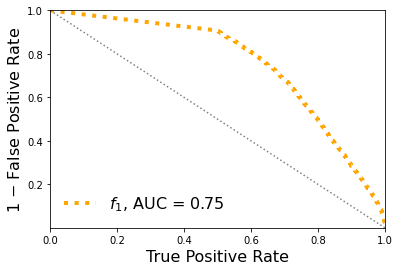

Classification score:


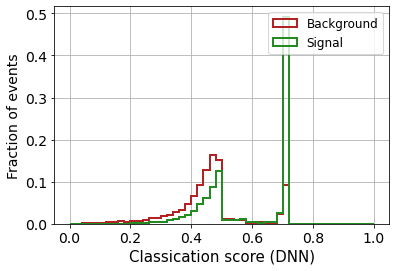


 ROC-AUC =  0.7534159621761871


In [29]:

# define the keras model
model = Sequential()
model.add(Dense(4, input_shape=(X_mon_train.shape[1],), activation='relu'))
model.add(Dropout(0.20))
# model.add(Dense(8, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [30]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.7534159621761871
